# SageMaker Multiple Regression Linear Learner: Predict Stock Market Price

##### Predicts Stock Market Price using 'Unemployment Rate' and 'Interest Rates'.
##### 1. Load dataset and perform Exploratory Data Analysis (EDA)
##### 2. Split the dataset into training and test data
##### 3. Upload the training data to S3
##### 4. Train linear regression model
##### 5. Deploy trained model as endpoint
##### 6. Cleanup - Delete the endpoint

## Import required libraries

In [2]:
# Import Numpy and check the version
import numpy as np
print(np.__version__)

# Import Numpy and check the version
import pandas as pd
print(pd.__version__)

# Updgrade Numpy version
!pip3 install numpy --upgrade

# Updgrade Pandas version
!pip3 install pandas --upgrade

import seaborn as sns
import matplotlib.pyplot as plt
import plotly.express as px # Interactive Data Visualization

import io
import numpy as np
import sagemaker.amazon.common as smac
import os

import sagemaker
import boto3

from sagemaker.deserializers import JSONDeserializer
from sagemaker.serializers import CSVSerializer

from sklearn.metrics import r2_score, mean_squared_error, mean_absolute_error
from math import sqrt

1.21.6
1.3.5


## 1. Load dataset and perform EDA

In [3]:
# Read the CSV file 
stock_df = pd.read_csv("data/S&P500_Stock_Data.csv")

# Load the top 6 instances
stock_df.head(6)

,Interest Rates,Employment,S&P 500 Price
0,1.943859,55.413571,2206.680582
1,2.258229,59.546305,2486.474488
2,2.215863,57.414687,2405.868337
3,1.977960,49.908353,2140.434475
4,2.437723,52.035492,2411.275663
5,2.143637,56.060598,2187.344909


In [4]:
# Display the feature columns
stock_df.columns

Index(['Interest Rates', 'Employment', 'S&P 500 Price'], dtype='object')

In [5]:
# Check the shape of the dataframe
stock_df.shape

(1000, 3)

In [6]:
# Check if any missing values are present in the dataframe
stock_df.isnull().sum()

Interest Rates    0
Employment        0
S&P 500 Price     0
dtype: int64

In [7]:
# Drop any rows containing null values
stock_df = stock_df.dropna()

In [8]:
# Show the datatypes for each column
stock_df.dtypes

Interest Rates    float64
Employment        float64
S&P 500 Price     float64
dtype: object

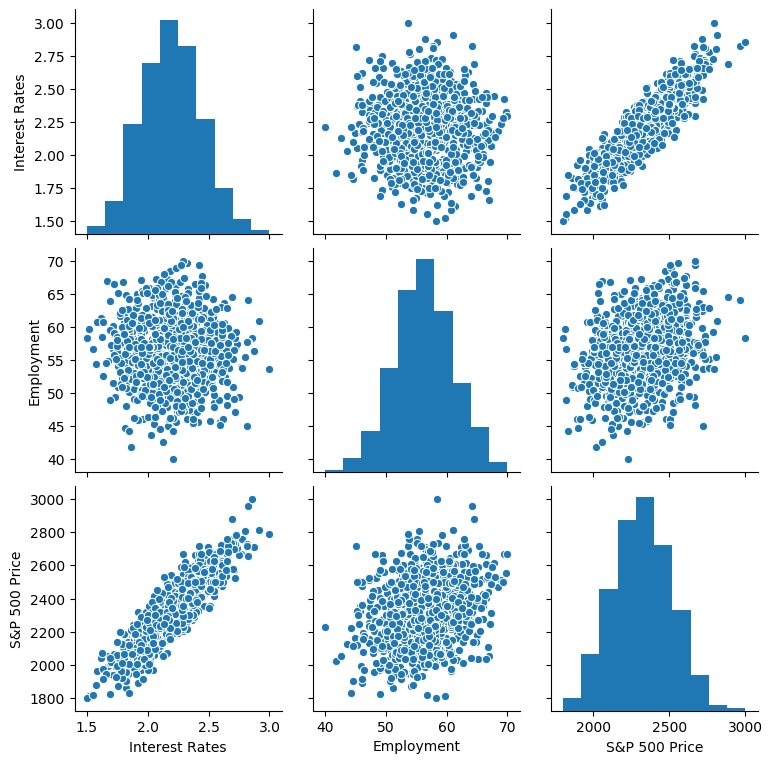

In [9]:
# Show scatterplots for joint relationships and histograms for univariate distributions
sns.pairplot(stock_df) 
plt.show()

## 2. Split the dataset into training and test data

In [10]:
# Assign feature columns corresponding to Independent variables to X
X = stock_df[['Interest Rates', 'Employment']]

# Assign feature column corresponding to dependent variable to y
y = stock_df['S&P 500 Price']


In [11]:
# Convert X and y to numpy arrays
X = np.array(X)
y = np.array(y)

In [12]:
# Convert the datatype to float32 (for use with SageMaker Linear Learner)
X = np.array(X).astype('float32')
y = np.array(y).astype('float32')

In [13]:
# Split into training and test data
from sklearn.model_selection import train_test_split
X_train, X_test, y_train, y_test= train_test_split(X, y, test_size = 0.2)

## 3. Upload the training data to S3

In [14]:
# convert from vector format to batch format (not necessary here)
# y_train = y_train[:,0]

In [15]:
# Convert numpy array data into RecordIO format (for use with SageMaker Linear Learner)
buf = io.BytesIO() # create an in-memory byte array (buf is a buffer I will be writing to)
smac.write_numpy_to_dense_tensor(buf, X_train, y_train)
buf.seek(0)

0

In [16]:
# Create a Sagemaker session
sagemaker_session = sagemaker.Session()

bucket = sagemaker_session.default_bucket() # Temporary bucket associated with this notebook
prefix = 'linear_learner_stocks' # Prefix is the subfolder within the bucket.
role = sagemaker.get_execution_role() # Execution role for the notebook instance.

# Upload the record-io data to S3 bucket for later training
key = 'linear-train-data'
boto3.resource('s3').Bucket(bucket).Object(os.path.join(prefix, 'train', key)).upload_fileobj(buf)

# Print out the training data location in s3
s3_train_data = 's3://{}/{}/train/{}'.format(bucket, prefix, key)
print('uploaded training data location: {}'.format(s3_train_data))

uploaded training data location: s3://sagemaker-us-east-1-628298263648/linear_learner_stocks/train/linear-train-data


## 4. Train linear regression model

In [17]:
# Define output location placeholder for trained ML model
output_location = 's3://{}/{}/output'.format(bucket, prefix)
print('Training artifacts will be uploaded to: {}'.format(output_location))

Training artifacts will be uploaded to: s3://sagemaker-us-east-1-628298263648/linear_learner_stocks/output


In [18]:
# Obtain reference to the SageMaker linearLearner container image
container = sagemaker.image_uris.retrieve("linear-learner", boto3.Session().region_name)
container

'382416733822.dkr.ecr.us-east-1.amazonaws.com/linear-learner:1'

In [19]:
# Set training parameters
linear = sagemaker.estimator.Estimator(container,
                                       role, 
                                       instance_count = 1, 
                                       instance_type = 'ml.m4.xlarge',
                                       output_path = output_location,
                                       sagemaker_session = sagemaker_session)

# The original car_df had 3 feature columns
# The 'S&P 500 Price' column was the dependent variable (y)
# The 'Employment' and 'Interest Rates' were the independent variables (X)
# Feature_dim must reflect the number of feature columns in X (2)
feature_dim = 2

linear.set_hyperparameters(feature_dim = feature_dim,
                           predictor_type = 'regressor',
                           mini_batch_size = 100,
                           epochs = 100,
                           num_models = 32,
                           loss = 'absolute_loss')

# Train the model
linear.fit({'train': s3_train_data})


INFO:sagemaker:Creating training-job with name: linear-learner-2023-04-06-19-34-05-529


2023-04-06 19:34:06 Starting - Starting the training job...
2023-04-06 19:34:32 Starting - Preparing the instances for training......
2023-04-06 19:35:34 Downloading - Downloading input data......
2023-04-06 19:36:23 Training - Downloading the training image...
2023-04-06 19:37:15 Training - Training image download completed. Training in progress....
2023-04-06 19:37:45 Uploading - Uploading generated training modelDocker entrypoint called with argument(s): train
Running default environment configuration script
[04/06/2023 19:37:31 INFO 139970850166592] Reading default configuration from /opt/amazon/lib/python3.7/site-packages/algorithm/resources/default-input.json: {'mini_batch_size': '1000', 'epochs': '15', 'feature_dim': 'auto', 'use_bias': 'true', 'binary_classifier_model_selection_criteria': 'accuracy', 'f_beta': '1.0', 'target_recall': '0.8', 'target_precision': '0.8', 'num_models': 'auto', 'num_calibration_samples': '10000000', 'init_method': 'uniform', 'init_scale': '0.07', 'in

## 5. Deploy trained model as endpoint

In [20]:
linear_regressor = linear.deploy(initial_instance_count = 1,
                                 instance_type = 'ml.m4.xlarge',
                                 serializer=CSVSerializer(),
                                 deserializer=JSONDeserializer())

INFO:sagemaker:Creating model with name: linear-learner-2023-04-06-19-38-29-992
INFO:sagemaker:Creating endpoint-config with name linear-learner-2023-04-06-19-38-29-992
INFO:sagemaker:Creating endpoint with name linear-learner-2023-04-06-19-38-29-992


-------!

In [21]:
# Obtain predictions for test data
response = linear_regressor.predict(X_test)
response

{'predictions': [{'score': 2188.78662109375},
  {'score': 2390.190673828125},
  {'score': 2281.40283203125},
  {'score': 2459.92578125},
  {'score': 2208.3720703125},
  {'score': 2224.879150390625},
  {'score': 2614.911865234375},
  {'score': 2346.85205078125},
  {'score': 2249.9638671875},
  {'score': 2375.97607421875},
  {'score': 2138.6259765625},
  {'score': 2252.283447265625},
  {'score': 2031.15380859375},
  {'score': 2223.573974609375},
  {'score': 2410.5078125},
  {'score': 2423.68310546875},
  {'score': 2388.386962890625},
  {'score': 2037.684814453125},
  {'score': 2301.20068359375},
  {'score': 2161.3779296875},
  {'score': 2222.093017578125},
  {'score': 2424.130859375},
  {'score': 2596.177734375},
  {'score': 2485.77099609375},
  {'score': 2090.496826171875},
  {'score': 2448.024169921875},
  {'score': 2023.50146484375},
  {'score': 2182.744384765625},
  {'score': 2091.34814453125},
  {'score': 2580.345947265625},
  {'score': 2272.92626953125},
  {'score': 2467.6049804687

In [22]:
# Flatten results and extract prediction score values
y_predict = np.array([r['score'] for r in response['predictions']])
y_predict

array([2188.78662109, 2390.19067383, 2281.40283203, 2459.92578125,
       2208.37207031, 2224.87915039, 2614.91186523, 2346.85205078,
       2249.96386719, 2375.97607422, 2138.62597656, 2252.28344727,
       2031.15380859, 2223.57397461, 2410.5078125 , 2423.68310547,
       2388.38696289, 2037.68481445, 2301.20068359, 2161.37792969,
       2222.09301758, 2424.13085938, 2596.17773438, 2485.77099609,
       2090.49682617, 2448.02416992, 2023.50146484, 2182.74438477,
       2091.34814453, 2580.34594727, 2272.92626953, 2467.60498047,
       2240.50610352, 2065.61401367, 2111.51782227, 2547.59130859,
       2270.21826172, 2617.39160156, 2363.32128906, 2173.60449219,
       2221.6105957 , 2341.57568359, 2150.12817383, 2127.12280273,
       2239.6628418 , 2319.64648438, 2468.91308594, 2333.88623047,
       2450.29541016, 2264.953125  , 2405.20996094, 2411.00537109,
       2327.35375977, 2227.72412109, 2425.61694336, 2256.75097656,
       2427.29296875, 2291.17211914, 2695.26489258, 2342.22119

In [23]:
# Display important metrics related to model performance
k = X_test.shape[1]
n = len(X_test)

# Calculate RMSE by comparing predicted 'S&P 500 Price' values (y_predict) against actual values (y_test)
RMSE = float(format(np.sqrt(mean_squared_error(y_test, y_predict)),'.3f'))

print('RMSE =', RMSE) 

RMSE = 65.374


## 6. Cleanup - Delete the endpoint

In [24]:
# Delete the endpoint
linear_regressor.delete_endpoint()

INFO:sagemaker:Deleting endpoint configuration with name: linear-learner-2023-04-06-19-38-29-992
INFO:sagemaker:Deleting endpoint with name: linear-learner-2023-04-06-19-38-29-992
